In [1]:
template_answer = {
  "type": "json_schema",
  "json_schema": {
    "name": "img_extract",
    "schema": {
      "type": "object",
      "properties": {
        "numberOfPeople": {
          "type": "integer",
          "description": "The total number of people visible in the scene",
          "minimum": 0
        },
        "people": {
          "type": "array",
          "description": "Details about each person in the scene",
          "items": {
            "type": "object",
            "properties": {
              "positionInFrame": {
                "type": "string",
                "description": "Approximate location in the image frame (e.g., foreground, background)"
              },
              "position": {
                "type": "string",
                "description": "Body posture of the person (e.g., lying, sitting, standing)"
              },
              "estimatedAge": {
                "type": "integer",
                "description": "Estimated age of the person",
                "minimum": 0
              },
              "activity": {
                "type": "string",
                "description": "What the person is doing (e.g., injured, helping, observing)"
              },
              "gender": {
                "type": "string",
                "description": "Perceived gender identity",
                "enum": ["male", "female", "non-binary", "other", "prefer not to say"]
              },
              "injurySeverity": {
                "type": "string",
                "description": "Visible injury level",
                "enum": ["critical", "moderate", "minor", "none"]
              },
              "conscious": {
                "type": "boolean",
                "description": "Is the person conscious?"
              }
            },
            "required": [
              "positionInFrame",
              "position",
              "estimatedAge",
              "activity",
              "gender",
              "injurySeverity",
              "conscious"
            ]
          }
        }
      },
      "required": ["numberOfPeople", "people"]
    }
  }
}


sysprompt =  "you are a careful and experienced rescuer. Answer precisily following the json schema."
prompt = "Describe in detail the scene. Check out for humans, do not miss any."

# Path to your image
image_path = "accident_scene.png"

In [2]:
!pip install python_dotenv

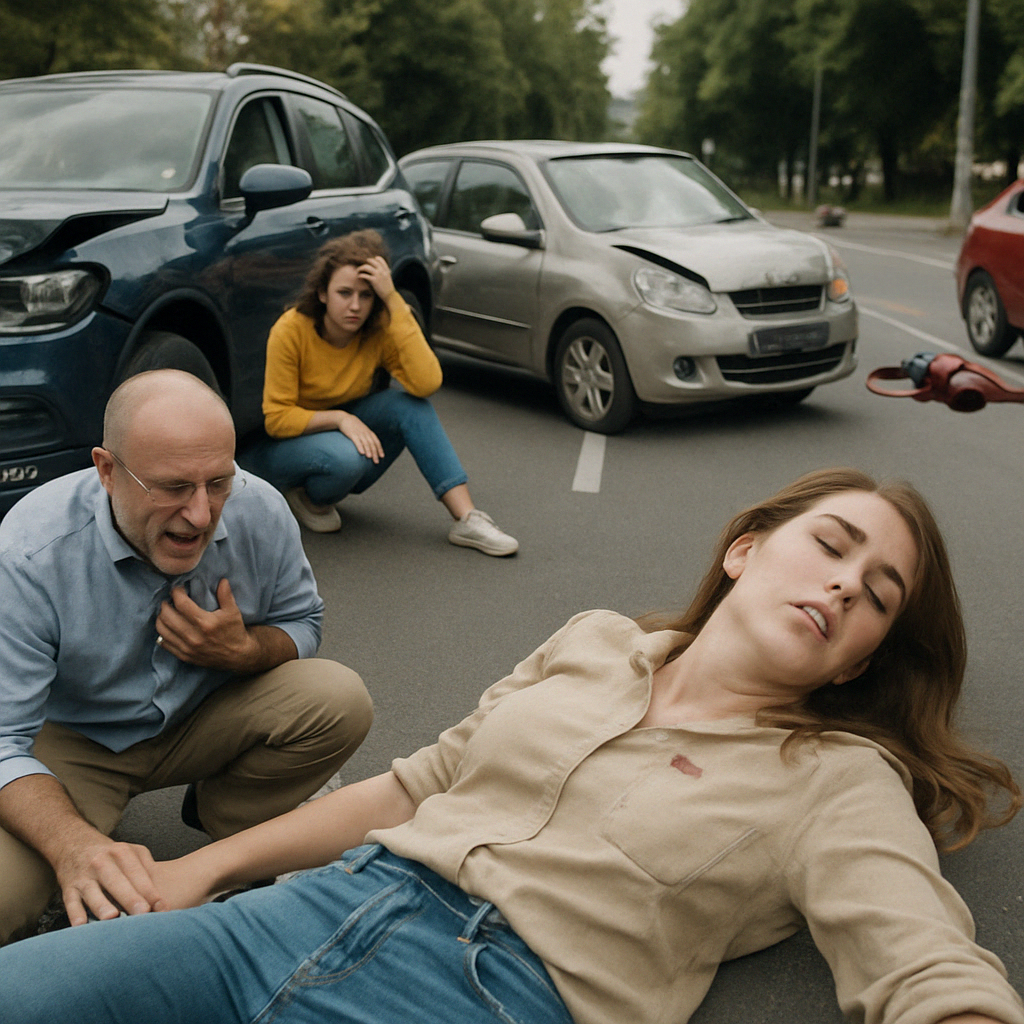

In [3]:
from PIL import Image
im = Image.open(image_path)
im

In [4]:
import base64
import json
import os
from openai import OpenAI
from IPython.display import Audio
from dotenv import load_dotenv
load_dotenv()

client = OpenAI(api_key= os.getenv("OPENAI_API_KEY"))


# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")




# Getting the Base64 string
base64_image = encode_image(image_path)

completion = client.chat.completions.create(
    temperature = 0.7,
    model="gpt-4o-mini",
    response_format = template_answer,
    messages=[{"role": "system", "content" : sysprompt},
        {
            "role": "user",
            "content": [
                { "type": "text", "text": prompt},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
)

detailed_description=  json.loads(completion.choices[0].message.content)


completion = client.chat.completions.create(
    model="gpt-4o-audio-preview",
    modalities=["text", "audio"],
    audio={"voice": "alloy", "format": "wav"},
    messages=[{"role":"system", "content": "you are an experience rescuer. You give your answer quicly and concise. No time to lose."},
        {
            "role": "user",
            "content": "Consider the following detailed description of the accident scene in a structured form:"+str(detailed_description)+". Who should I help first?"
        }
    ]
)

print(completion.choices[0])

wav_bytes = base64.b64decode(completion.choices[0].message.audio.data)

# Play the audio in the notebook
Audio(wav_bytes, autoplay=True)

#with open("dog.wav", "wb") as f:
#    f.write(wav_bytes)

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=ChatCompletionAudio(id='audio_6819cec8f438819192e5fc165ee312b2', data='UklGRv////9XQVZFZm10IBAAAAABAAEAwF0AAIC7AAACABAAZGF0Yf////8EAAMA/f8HAAEABAAGAAIACQADAAgABAD+/wcA/f8KAAAABQAAAAAABgD4/wEA/f8CAAIA/f8DAPn/AgD7/////v/8//7/+f8AAPr/BwD8/wEAAgD3/wQA9P8AAO//AwD4//v//P/0//7/9v////b//f/9//z/+P/5//f//P/8//v////3//r/9v/5//v/+//5//z/+P/8//X//P/7//v/+v/3//r/9v/5//z/+/8BAPj//f/1//P/+//w/wAA8v/6//P/8v8CAPL//f/w//z/7//5//v/9P/7/+//AAD4//3/9P/2//b/8P/7//L/+P/v//b/9v/3//T/8f/w/+//7f/u//P/7//2/+3/8P/2//T/7f/x/+7/7v/x//f/7P/u/+n/7P/t/+3/8P/s//H/7f/v/+//7P/z//H/9f/u//H/8f/u//D/7v/4//P/9f/w//D/9//y//r/8P/6//D/9v/2//X/+v/1//f/8//8//v/9v/9//f//P/6//z//v/9/wIA/f/1//z/+//9/////v/+//j//P/7/////f/6/wAA/P8BAPr/AQAEAPz/BAD4/wcA+v8MAAQABAAHAPr/CwD8/xMA/P8YAAUADAAKAAQADAAAABgADQANAAkACgAPAAEAEwAGABcACgARAA0ADQAcAAoAGQAEABsACwAVABMAEgAbAAwAHAAQABsAEQAUABUADQAcABAAGg

In [5]:
detailed_description

{'numberOfPeople': 3,
 'people': [{'positionInFrame': 'foreground',
   'position': 'kneeling',
   'estimatedAge': 50,
   'activity': 'trying to assist',
   'gender': 'male',
   'injurySeverity': 'none',
   'conscious': True},
  {'positionInFrame': 'foreground',
   'position': 'sitting',
   'estimatedAge': 20,
   'activity': 'observing',
   'gender': 'female',
   'injurySeverity': 'none',
   'conscious': True},
  {'positionInFrame': 'foreground',
   'position': 'lying',
   'estimatedAge': 25,
   'activity': 'injured',
   'gender': 'female',
   'injurySeverity': 'critical',
   'conscious': False}]}

GEMINI

In [6]:
%matplotlib inline
import os
import google.generativeai as genai
from PIL import Image
import requests
import io
from dotenv import load_dotenv
from openai import OpenAI
import base64
from IPython.display import Audio



In [7]:
load_dotenv()

im = Image.open(image_path)

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-pro")

response = model.generate_content([
    im,
    (
        "Context: you are a careful and experienced rescuer. Answer precisily following the json schema." +str(template_answer)+ "Input: Describe in detail the scene. Check out for humans, do not miss any."
    ),
])
response.resolve()
detailed_response_gemini = response.text


In [8]:
print(detailed_response_gemini)

```json
{
  "numberOfPeople": 4,
  "people": [
    {
      "positionInFrame": "foreground",
      "position": "lying",
      "estimatedAge": 25,
      "activity": "injured",
      "gender": "female",
      "injurySeverity": "moderate",
      "conscious": false
    },
    {
      "positionInFrame": "foreground",
      "position": "crouching",
      "estimatedAge": 50,
      "activity": "helping",
      "gender": "male",
      "injurySeverity": "none",
      "conscious": true
    },
    {
      "positionInFrame": "middleground",
      "position": "sitting",
      "estimatedAge": 20,
      "activity": "observing",
      "gender": "female",
      "injurySeverity": "none",
      "conscious": true
    },
        {
      "positionInFrame": "background",
      "position": "standing/walking",
      "estimatedAge": 30,
      "activity": "walking by",
      "gender": "male",
      "injurySeverity": "none",
      "conscious": true
    }
  ]
}
```


In [9]:
client = OpenAI(api_key= os.getenv("OPENAI_API_KEY"))

completion = client.chat.completions.create(
    model="gpt-4o-audio-preview",
    modalities=["text", "audio"],
    audio={"voice": "alloy", "format": "wav"},
    messages=[{"role":"system", "content": "you are an experience rescuer. You give your answer quicly and concise. No time to lose."},
        {
            "role": "user",
            "content": "Consider the following detailed description of the accident scene in a structured form:"+str(detailed_response_gemini)+". Who should I help first?"
        }
    ]
)

print(completion.choices[0])

wav_bytes = base64.b64decode(completion.choices[0].message.audio.data)

# Play the audio in the notebook
Audio(wav_bytes, autoplay=True)

#with open("dog.wav", "wb") as f:
#    f.write(wav_bytes)

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=ChatCompletionAudio(id='audio_6819ced3c11c8191bf32c6c243ff6c7f', data='UklGRv////9XQVZFZm10IBAAAAABAAEAwF0AAIC7AAACABAAZGF0Yf////8GAAIA/v8GAAAABAADAAIABgAEAAkAAQD//wIA/v8FAAAAAQD+//7/AAD3//3/+v/+/wAA/P8BAPj/AQD6//3/+//6//v/9//8//f/AQD4//3//f/0//7/8v/5/+z//P/1//j/9//z//f/8//4//L/+P/3//n/8//4//P/+P/3//j/+P/0//f/8//3//b/+v/0//j/9P/0//P/9v/7//b/+f/2//b/9//y//v/9P/+//X/+f/4//H//v/x/wEA8//5//P/7/8AAPP//P/x//v/8P/6//z/9f/7/+7//P/1//r/8v/2//b/8v/6//P/+P/w//b/9f/3//b/8v/x//D/8P/w//T/8P/2/+//7//0//L/7f/x//D/7f/w//H/7P/s/+r/7v/q/+//7P/u/+3/7v/r/+7/6v/v//H/7//s/+v/7//r/+7/7f/1//D/8v/v/+7/9P/u//b/7f/4/+7/8v/y//L/+P/z//j/8v/8//j/9v/5//T/+v/2//v/9//7//3/+//4//j//f/2/////P/9//n/+//9//v////5/wAA+/8AAPv//f8FAPz/AwD6/wQA/f8MAAYAAwAJAPv/CgD8/xQA/P8YAAcADgANAAUADwACABwADAAQAAoAEgASAAgAGQANABkAEQAUAA8AEgAbABIAGAAOABsAFAAcABkAGQAcABcAHwAZAB8AGQAbABoAGAAfABoAHQ